# [E-15] OCR

Node에서 살펴본 Google OCR API, keras-ocr, Tesseract 를 이용해서 ORC 기능을 구현해 보자. 
이번 프로젝트의 목적은 OCR 3개 모델에 대한 구현을 해보는 것이 1차 목표이고, 서비스 런칭을 가정하고 적합한 모델을 선정하기 위해 테스트 평가 기준을 정하고 테스트를 진행하여 결론을 도출하는 것을 2차 목표로 한다

#### 구현하고자 하는 서비스 - 서비스명: 🧸테디랑 📙책이랑
우리 회사에서 이번에 유아용 인형을 개발하면서 아이들이 그림책을 조금더 친숙하게 느끼도록 🧸테디 인형 👁️‍🗨️눈을 통해 📙그림책을 인식해서 
제목을 읽어주는 서비스를 기획했다고 가정한다. 

우리의 목표는 서비스의 목적에 맞는 OCR를 기술 찾기위해 평가 기준을 제시하고 평가 결과를 분석하여 가장 나은 모델을 선정하고자 한다. 




공통 import

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

from google.cloud import vision
import io

import keras_ocr
import cv2

import os
import pytesseract
from PIL import Image
from pytesseract import Output

import glob

In [2]:
def get_img_path_n_file_list(work_dir= './images/ocr/picturebooks', img_ext='.png'):
  img_path_list = [img_path for img_path in glob.glob(work_dir + '/*') if img_path.endswith(img_ext)]
  img_file_list = [img_file for img_file in os.listdir(work_dir) if img_file.endswith(img_ext)]
  return img_path_list, img_file_list

In [3]:
work_dir = './images/ocr/picturebooks'
img_ext = '.png'
img_path_list, img_file_list = get_img_path_n_file_list(work_dir, img_ext)

In [4]:
get_img_path_n_file_list(work_dir, img_ext)

(['./images/ocr/picturebooks\\1.png',
  './images/ocr/picturebooks\\2.png',
  './images/ocr/picturebooks\\3.png',
  './images/ocr/picturebooks\\4.png',
  './images/ocr/picturebooks\\s_1.png',
  './images/ocr/picturebooks\\s_2.png',
  './images/ocr/picturebooks\\s_3.png',
  './images/ocr/picturebooks\\s_4.png'],
 ['1.png',
  '2.png',
  '3.png',
  '4.png',
  's_1.png',
  's_2.png',
  's_3.png',
  's_4.png'])

In [5]:
img_path_list.sort()
img_path_list

['./images/ocr/picturebooks\\1.png',
 './images/ocr/picturebooks\\2.png',
 './images/ocr/picturebooks\\3.png',
 './images/ocr/picturebooks\\4.png',
 './images/ocr/picturebooks\\s_1.png',
 './images/ocr/picturebooks\\s_2.png',
 './images/ocr/picturebooks\\s_3.png',
 './images/ocr/picturebooks\\s_4.png']

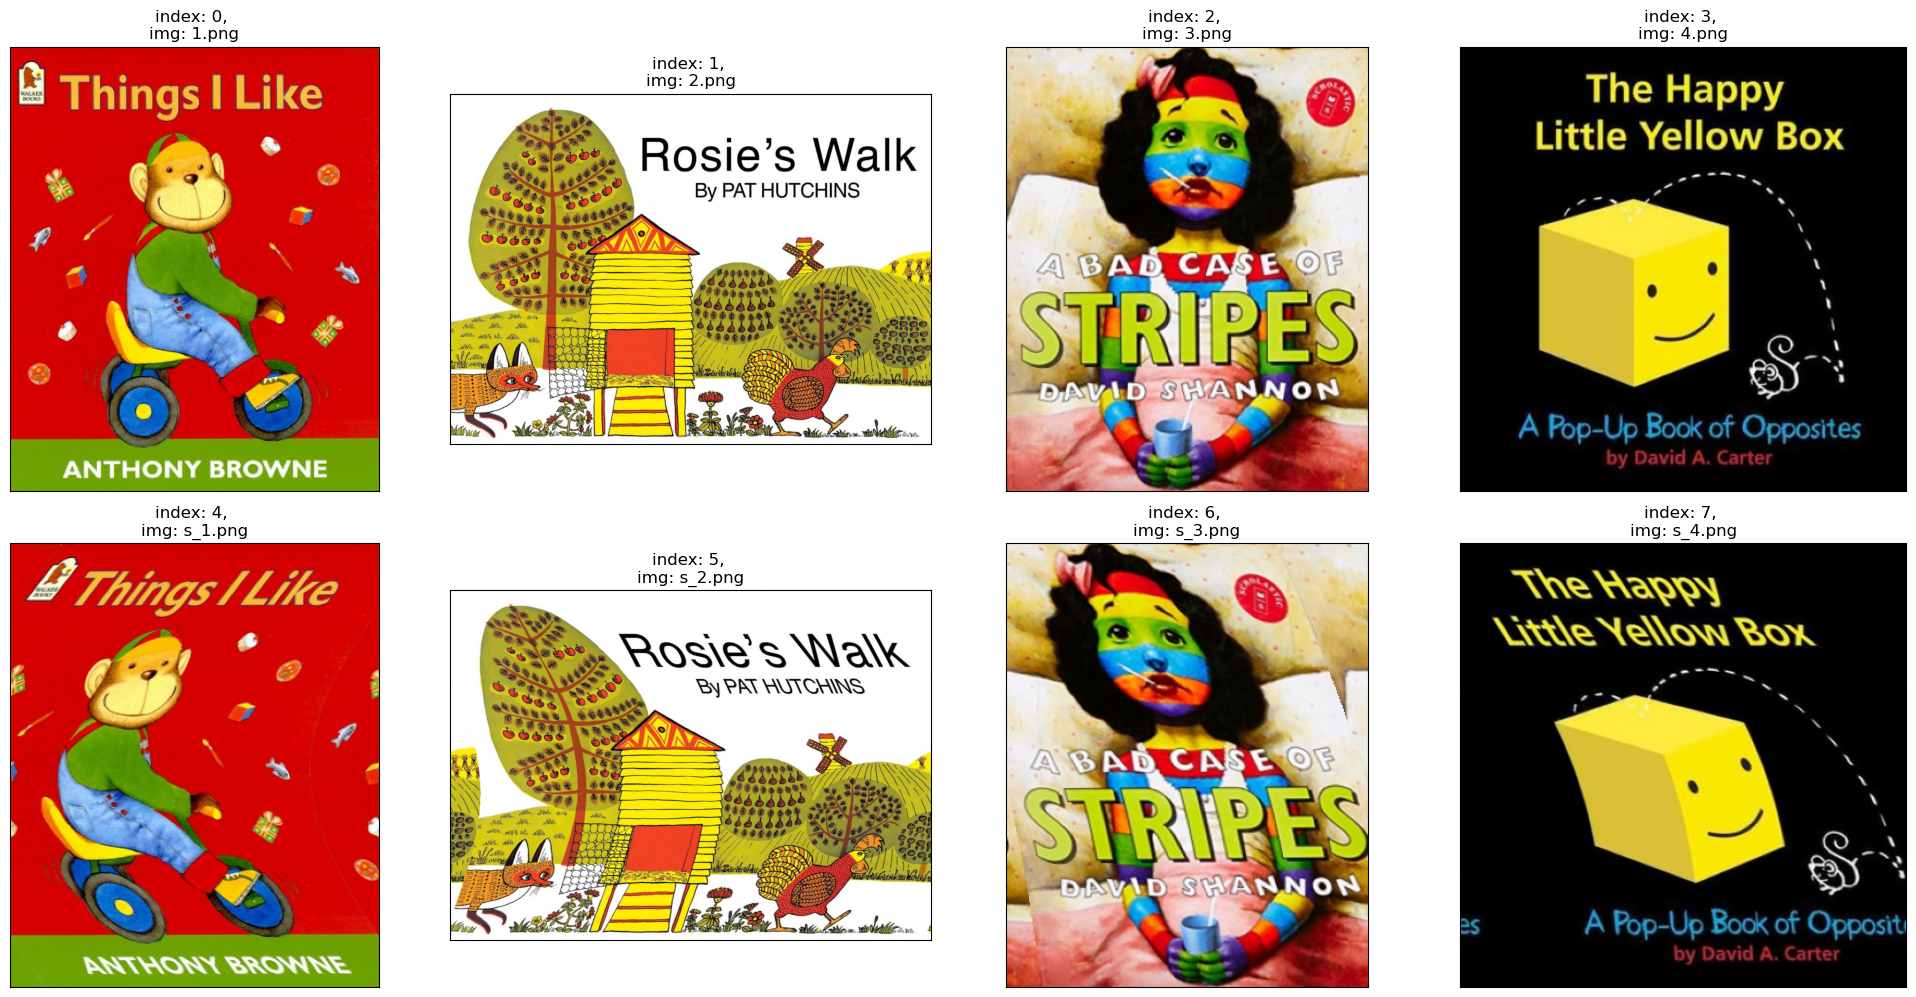

In [6]:
plt.figure(figsize=(20, 20))

for i, (img_path, img_file) in enumerate(zip(img_path_list, img_file_list)):
    plt.subplot(4,4, i+1)
    plt.title(f'index: {i}, \nimg: {img_file}')

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()



# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

## step 2-1 Google OCR 

In [7]:
# 인증키
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  'my_google_api_key.json'

In [8]:
# Google OCR API 이용 함수
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    only_text_list = []
    vertices_tuple_list = []
    for text in texts:
       print('\n"{}"'.format(text.description))
       only_text_list.append(text.description)

       vertices = (['({},{})'.format(vertex.x, vertex.y)
                  for vertex in text.bounding_poly.vertices])
    
       vertices_tuple = [(vertex.x, vertex.y) for vertex in text.bounding_poly.vertices]
       vertices_tuple_list.append(vertices_tuple)

       print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    
    return only_text_list, vertices_tuple_list

In [9]:
google_ocr_dict = {}
for img_path, img_file in zip(img_path_list, img_file_list):
    print(f'---------------{img_file}---------------')
    texts, vertices_list = detect_text(img_path)
    google_ocr_dict[img_path] = {'texts': texts, 'vertices_list': vertices_list}

---------------1.png---------------
Texts:

"WALKER
Things I Like
OLD
ANTHONY BROWNE"
bounds: (9,18),(293,18),(293,396),(9,396)

"WALKER"
bounds: (9,41),(29,41),(29,44),(9,44)

"Things"
bounds: (47,25),(172,21),(173,61),(48,65)

"I"
bounds: (184,21),(194,21),(195,60),(185,60)

"Like"
bounds: (203,21),(286,19),(287,58),(204,60)

"OLD"
bounds: (294,255),(282,269),(277,264),(289,250)

"ANTHONY"
bounds: (48,380),(175,380),(175,396),(48,396)

"BROWNE"
bounds: (184,380),(290,380),(290,396),(184,396)
---------------2.png---------------
Texts:

"l
ال .
Illmin
W
ال
miNk.
WW
VIL
Rosie's Walk
By PAT HUTCHINS
SMPN
Wushnicia
aniven."
bounds: (-4,97),(1100,97),(1100,783),(-4,783)

"l"
bounds: (-4,534),(10,534),(10,544),(-4,544)

"ال"
bounds: (64,567),(88,566),(89,581),(65,582)

"."
bounds: (52,568),(55,568),(56,583),(53,583)

"Illmin"
bounds: (8,587),(76,584),(77,611),(9,614)

"W"
bounds: (136,547),(149,547),(149,560),(136,560)

"ال"
bounds: (161,520),(165,520),(165,538),(161,538)

"miNk"
bounds: (1

In [10]:
google_ocr_dict

{'./images/ocr/picturebooks\\1.png': {'texts': ['WALKER\nThings I Like\nOLD\nANTHONY BROWNE',
   'WALKER',
   'Things',
   'I',
   'Like',
   'OLD',
   'ANTHONY',
   'BROWNE'],
  'vertices_list': [[(9, 18), (293, 18), (293, 396), (9, 396)],
   [(9, 41), (29, 41), (29, 44), (9, 44)],
   [(47, 25), (172, 21), (173, 61), (48, 65)],
   [(184, 21), (194, 21), (195, 60), (185, 60)],
   [(203, 21), (286, 19), (287, 58), (204, 60)],
   [(294, 255), (282, 269), (277, 264), (289, 250)],
   [(48, 380), (175, 380), (175, 396), (48, 396)],
   [(184, 380), (290, 380), (290, 396), (184, 396)]]},
 './images/ocr/picturebooks\\2.png': {'texts': ["l\nال .\nIllmin\nW\nال\nmiNk.\nWW\nVIL\nRosie's Walk\nBy PAT HUTCHINS\nSMPN\nWushnicia\naniven.",
   'l',
   'ال',
   '.',
   'Illmin',
   'W',
   'ال',
   'miNk',
   '.',
   'WW',
   'VIL',
   "Rosie's",
   'Walk',
   'By',
   'PAT',
   'HUTCHINS',
   'SMPN',
   'Wushnicia',
   'aniven',
   '.'],
  'vertices_list': [[(-4, 97), (1100, 97), (1100, 783), (-4, 783

In [11]:
google_ocr_text_pos_list = []
google_ocr_text_list = []
for i, (img_path, result_dict) in enumerate(google_ocr_dict.items()):
    google_ocr_text_list.append((i, result_dict['texts']))
    google_ocr_text_pos_list.append((i, result_dict['vertices_list']))

In [12]:
google_ocr_text_list

[(0,
  ['WALKER\nThings I Like\nOLD\nANTHONY BROWNE',
   'WALKER',
   'Things',
   'I',
   'Like',
   'OLD',
   'ANTHONY',
   'BROWNE']),
 (1,
  ["l\nال .\nIllmin\nW\nال\nmiNk.\nWW\nVIL\nRosie's Walk\nBy PAT HUTCHINS\nSMPN\nWushnicia\naniven.",
   'l',
   'ال',
   '.',
   'Illmin',
   'W',
   'ال',
   'miNk',
   '.',
   'WW',
   'VIL',
   "Rosie's",
   'Walk',
   'By',
   'PAT',
   'HUTCHINS',
   'SMPN',
   'Wushnicia',
   'aniven',
   '.']),
 (2,
  ['STIC\nA BAD CASE OF\nSTRIPES\nDAVID SHANNON',
   'STIC',
   'A',
   'BAD',
   'CASE',
   'OF',
   'STRIPES',
   'DAVID',
   'SHANNON']),
 (3,
  ['The Happy\nLittle Yellow Box\nA Pop-Up Book of Opposites\nby David A. Carter',
   'The',
   'Happy',
   'Little',
   'Yellow',
   'Box',
   'A',
   'Pop',
   '-',
   'Up',
   'Book',
   'of',
   'Opposites',
   'by',
   'David',
   'A.',
   'Carter']),
 (4,
  ['B\nWALKER\nThings/Like\n52\nDID\nANTHONY BROWNE',
   'B',
   'WALKER',
   'Things',
   '/',
   'Like',
   '52',
   'DID',
   'ANTHONY',


In [13]:
google_ocr_text_pos_list

[(0,
  [[(9, 18), (293, 18), (293, 396), (9, 396)],
   [(9, 41), (29, 41), (29, 44), (9, 44)],
   [(47, 25), (172, 21), (173, 61), (48, 65)],
   [(184, 21), (194, 21), (195, 60), (185, 60)],
   [(203, 21), (286, 19), (287, 58), (204, 60)],
   [(294, 255), (282, 269), (277, 264), (289, 250)],
   [(48, 380), (175, 380), (175, 396), (48, 396)],
   [(184, 380), (290, 380), (290, 396), (184, 396)]]),
 (1,
  [[(-4, 97), (1100, 97), (1100, 783), (-4, 783)],
   [(-4, 534), (10, 534), (10, 544), (-4, 544)],
   [(64, 567), (88, 566), (89, 581), (65, 582)],
   [(52, 568), (55, 568), (56, 583), (53, 583)],
   [(8, 587), (76, 584), (77, 611), (9, 614)],
   [(136, 547), (149, 547), (149, 560), (136, 560)],
   [(161, 520), (165, 520), (165, 538), (161, 538)],
   [(173, 502), (200, 501), (200, 512), (173, 513)],
   [(198, 502), (201, 502), (201, 512), (198, 512)],
   [(177, 555), (196, 556), (196, 567), (177, 566)],
   [(259, 509), (275, 509), (275, 518), (259, 518)],
   [(437, 101), (783, 101), (783,

## step 2-2 Keras-OCR

In [14]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

images = [ keras_ocr.tools.read(f) for f in img_path_list]
prediction_groups = [pipeline.recognize([f]) for f in img_path_list]


Looking for C:\Users\peunj\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\peunj\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


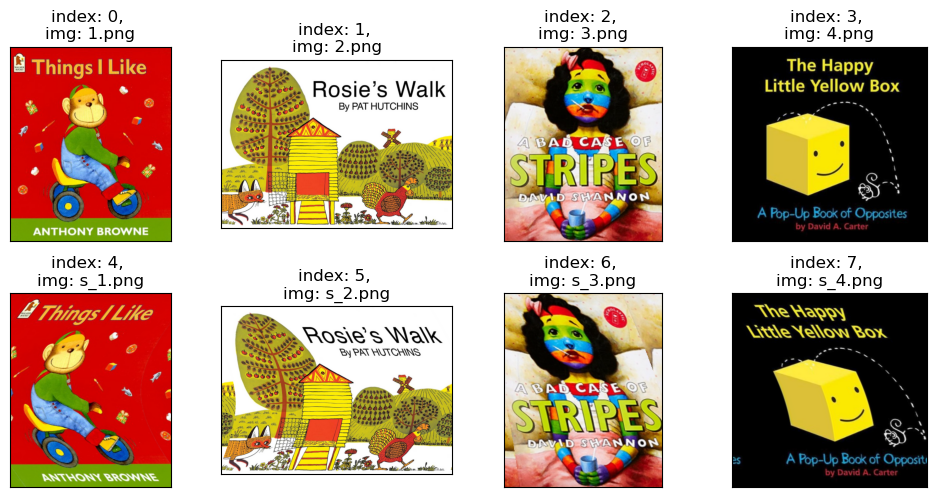

In [15]:
plt.figure(figsize=(10, 10))

for i, (img_path, img_file) in enumerate(zip(img_path_list, img_file_list)):
    plt.subplot(4,4, i+1)
    plt.title(f'index: {i}, \nimg: {img_file}')

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

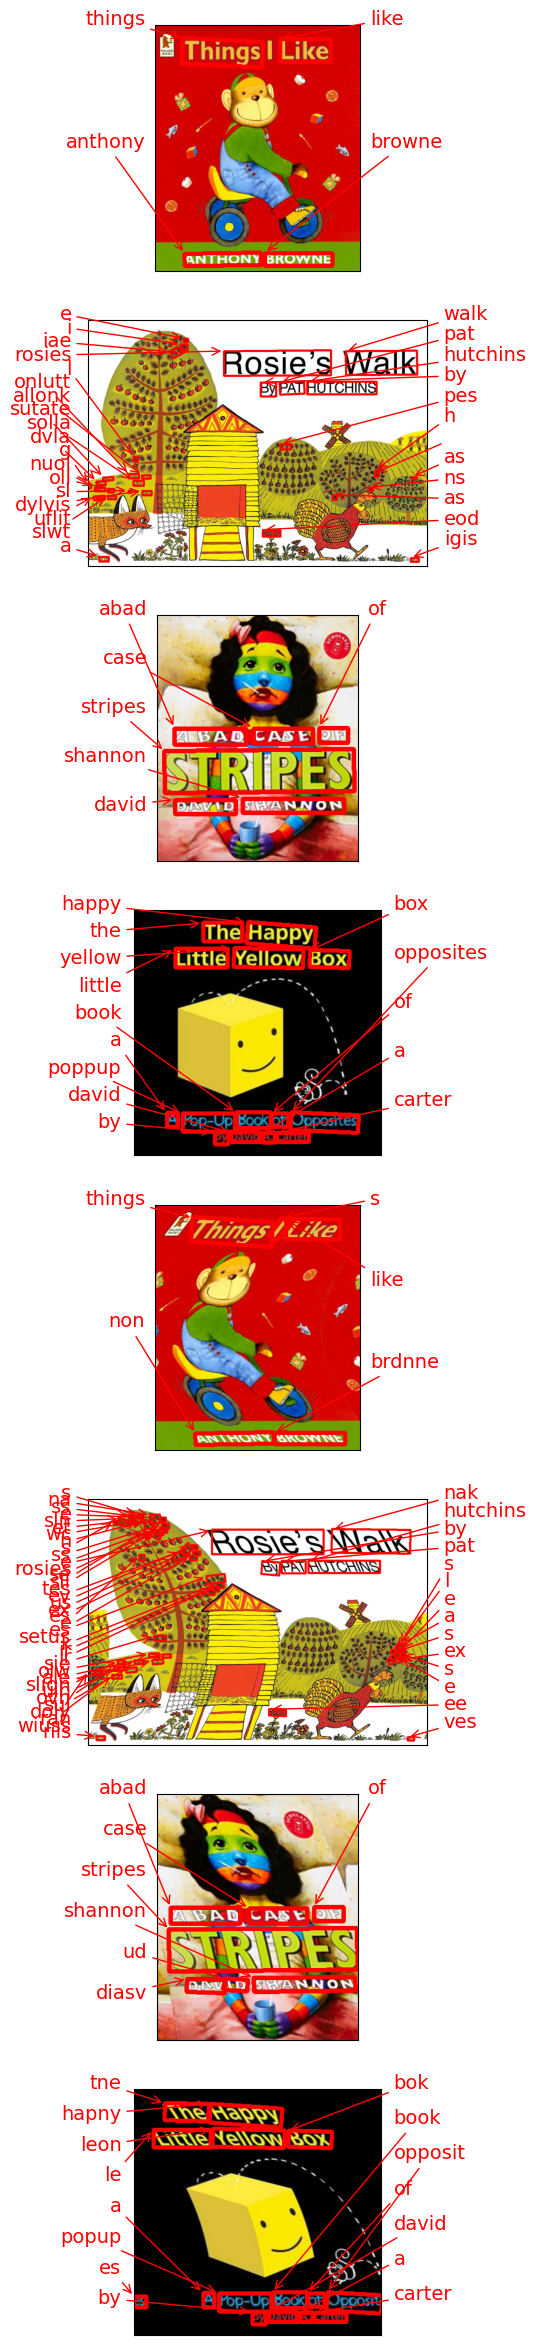

In [16]:
def draw_keras_ocr(images, prediction_groups):
    # Plot the predictions
    fig, axs = plt.subplots(nrows=len(images), figsize=(20, 30))
    for idx, ax in enumerate(axs):
        keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)
        
draw_keras_ocr(images, prediction_groups)

In [17]:
keras_ocr_dict = {}
for idx, img_path in enumerate(img_path_list):
  keras_ocr_dict[img_path] = prediction_groups[idx][0]

In [18]:
keras_ocr_dict

{'./images/ocr/picturebooks\\1.png': [('like',
   array([[207.,  23.],
          [291.,  23.],
          [291.,  61.],
          [207.,  61.]], dtype=float32)),
  ('things',
   array([[ 46.454422,  21.76006 ],
          [179.3134  ,  28.294106],
          [177.21983 ,  70.86328 ],
          [ 44.360855,  64.32923 ]], dtype=float32)),
  ('anthony',
   array([[ 48.845886, 380.04688 ],
          [175.97176 , 378.89117 ],
          [176.16199 , 399.8167  ],
          [ 49.036118, 400.9724  ]], dtype=float32)),
  ('browne',
   array([[182., 379.],
          [294., 379.],
          [294., 400.],
          [182., 400.]], dtype=float32))],
 './images/ocr/picturebooks\\2.png': [('e',
   array([[310.44922,  60.15625],
          [324.41406,  60.15625],
          [324.41406,  71.97266],
          [310.44922,  71.97266]], dtype=float32)),
  ('i',
   array([[301.85547 ,  79.49219 ],
          [323.33984 ,  79.49219 ],
          [323.33984 ,  98.828125],
          [301.85547 ,  98.828125]], dtype=flo

In [19]:
keras_ocr_text_pos_list = []
keras_ocr_text_list = []
for idx, img_path in enumerate(img_path_list):
  keras_ocr_text_pos_list.append([idx, list(zip(*keras_ocr_dict[img_path]))[1]])
  keras_ocr_text_list.append([idx, list(zip(*keras_ocr_dict[img_path]))[0]])

In [20]:
keras_ocr_text_list

[[0, ('like', 'things', 'anthony', 'browne')],
 [1,
  ('e',
   'i',
   'iae',
   'rosies',
   'walk',
   'pat',
   'hutchins',
   'by',
   'pes',
   'l',
   'h',
   '',
   'onlutt',
   'allonk',
   'as',
   'sutate',
   'solla',
   'dvla',
   'g',
   'nuol',
   'ns',
   'oll',
   'sl',
   'dylvis',
   'as',
   'uflit',
   'slwt',
   'eod',
   'a',
   'igis')],
 [2, ('of', 'abad', 'case', 'stripes', 'shannon', 'david')],
 [3,
  ('the',
   'happy',
   'little',
   'yellow',
   'box',
   'book',
   'a',
   'opposites',
   'poppup',
   'of',
   'david',
   'by',
   'a',
   'carter')],
 [4, ('things', 'like', 's', 'non', 'brdnne')],
 [5,
  ('s',
   'na',
   'ss',
   'e',
   'sln',
   'wc',
   'et',
   'n',
   's',
   'ss',
   'e',
   'se',
   'rosies',
   'nak',
   'sll',
   'tes',
   'ev',
   'us',
   'es',
   'ex',
   'e',
   'es',
   'hutchins',
   'pat',
   'by',
   'setus',
   'k',
   'ir',
   'ir',
   'sie',
   's',
   'l',
   'e',
   'a',
   's',
   'olw',
   's',
   'ale',
   'ex',


## step 2-3 Tesseract


In [21]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output', lang='eng'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    recognized_data = pytesseract.image_to_data(
        image, lang=lang,    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    
    cropped_image_dict = {}
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]

        if level == top_level:
            left = recognized_data['left'][i]

            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            
            height = recognized_data['height'][i]
            
            img_file = img_path.split('/')[-1][:-4]
            output_img_path = os.path.join(output_path, f"{img_file + '_' + str(index).zfill(4)}.png")
            print(output_img_path)
            
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_dict[output_img_path] = [(left, top), (left+width, top), (left+width, top+height), (left, top+height)]
            index += 1
    return cropped_image_dict


In [22]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text = recognized_data['text']
        print(text)
        text_list.append(text)
    print("Done")
    return text_list

In [23]:
img_path_list

['./images/ocr/picturebooks\\1.png',
 './images/ocr/picturebooks\\2.png',
 './images/ocr/picturebooks\\3.png',
 './images/ocr/picturebooks\\4.png',
 './images/ocr/picturebooks\\s_1.png',
 './images/ocr/picturebooks\\s_2.png',
 './images/ocr/picturebooks\\s_3.png',
 './images/ocr/picturebooks\\s_4.png']

In [24]:
output_dir = './images/ocr/picturebooks/output'

tesseract_ocr_dict = {}
for img_path, img_file in zip(img_path_list, img_file_list):
    print(f'---------------{img_file}---------------')
    img_path = img_path.replace('\\', '/')
    cropped_image_dict = crop_word_regions(img_path, output_dir)
    

    text_list = recognize_images(cropped_image_dict.keys())
    tesseract_ocr_dict[img_file] = {'text_list': text_list, 'cropped_image_dict': cropped_image_dict}

---------------1.png---------------
./images/ocr/picturebooks/output\1_0000.png
./images/ocr/picturebooks/output\1_0001.png
./images/ocr/picturebooks/output\1_0002.png
./images/ocr/picturebooks/output\1_0003.png
./images/ocr/picturebooks/output\1_0004.png
./images/ocr/picturebooks/output\1_0005.png
./images/ocr/picturebooks/output\1_0006.png
./images/ocr/picturebooks/output\1_0007.png
./images/ocr/picturebooks/output\1_0008.png
./images/ocr/picturebooks/output\1_0009.png
gsil

mm

¢

a

:.

4 bs

é

Ye

ANTHONY


Done
---------------2.png---------------
./images/ocr/picturebooks/output\2_0000.png
./images/ocr/picturebooks/output\2_0001.png
./images/ocr/picturebooks/output\2_0002.png
./images/ocr/picturebooks/output\2_0003.png
./images/ocr/picturebooks/output\2_0004.png
./images/ocr/picturebooks/output\2_0005.png
./images/ocr/picturebooks/output\2_0006.png
./images/ocr/picturebooks/output\2_0007.png
./images/ocr/picturebooks/output\2_0008.png
./images/ocr/picturebooks/output\2_0009.png


In [25]:
tesseract_ocr_dict

{'1.png': {'text_list': ['gsil\n',
   'mm\n',
   '¢\n',
   'a\n',
   ':.\n',
   '4 bs\n',
   'é\n',
   'Ye\n',
   'ANTHONY\n',
   ''],
  'cropped_image_dict': {'./images/ocr/picturebooks/output\\1_0000.png': [(135,
     26),
    (216, 26),
    (216, 65),
    (135, 65)],
   './images/ocr/picturebooks/output\\1_0001.png': [(163, 98),
    (197, 98),
    (197, 122),
    (163, 122)],
   './images/ocr/picturebooks/output\\1_0002.png': [(114, 112),
    (126, 112),
    (126, 136),
    (114, 136)],
   './images/ocr/picturebooks/output\\1_0003.png': [(73, 167),
    (78, 167),
    (78, 173),
    (73, 173)],
   './images/ocr/picturebooks/output\\1_0004.png': [(63, 202),
    (70, 202),
    (70, 217),
    (63, 217)],
   './images/ocr/picturebooks/output\\1_0005.png': [(182, 181),
    (249, 181),
    (249, 204),
    (182, 204)],
   './images/ocr/picturebooks/output\\1_0006.png': [(40, 244),
    (61, 244),
    (61, 275),
    (40, 275)],
   './images/ocr/picturebooks/output\\1_0007.png': [(290, 244),
 

In [26]:
tesseract_ocr_text_pos_list = []
tesseract_ocr_text_list = []
for i, (img_path, tesseract_ocr_result) in enumerate(tesseract_ocr_dict.items()):
  tesseract_ocr_text_list.append([i, tesseract_ocr_result['text_list']])
  tesseract_ocr_text_pos_list.append([i, list(tesseract_ocr_result['cropped_image_dict'].values())])

In [27]:
tesseract_ocr_dict

{'1.png': {'text_list': ['gsil\n',
   'mm\n',
   '¢\n',
   'a\n',
   ':.\n',
   '4 bs\n',
   'é\n',
   'Ye\n',
   'ANTHONY\n',
   ''],
  'cropped_image_dict': {'./images/ocr/picturebooks/output\\1_0000.png': [(135,
     26),
    (216, 26),
    (216, 65),
    (135, 65)],
   './images/ocr/picturebooks/output\\1_0001.png': [(163, 98),
    (197, 98),
    (197, 122),
    (163, 122)],
   './images/ocr/picturebooks/output\\1_0002.png': [(114, 112),
    (126, 112),
    (126, 136),
    (114, 136)],
   './images/ocr/picturebooks/output\\1_0003.png': [(73, 167),
    (78, 167),
    (78, 173),
    (73, 173)],
   './images/ocr/picturebooks/output\\1_0004.png': [(63, 202),
    (70, 202),
    (70, 217),
    (63, 217)],
   './images/ocr/picturebooks/output\\1_0005.png': [(182, 181),
    (249, 181),
    (249, 204),
    (182, 204)],
   './images/ocr/picturebooks/output\\1_0006.png': [(40, 244),
    (61, 244),
    (61, 275),
    (40, 275)],
   './images/ocr/picturebooks/output\\1_0007.png': [(290, 244),
 

In [28]:
tesseract_ocr_text_pos_list

[[0,
  [[(135, 26), (216, 26), (216, 65), (135, 65)],
   [(163, 98), (197, 98), (197, 122), (163, 122)],
   [(114, 112), (126, 112), (126, 136), (114, 136)],
   [(73, 167), (78, 167), (78, 173), (73, 173)],
   [(63, 202), (70, 202), (70, 217), (63, 217)],
   [(182, 181), (249, 181), (249, 204), (182, 204)],
   [(40, 244), (61, 244), (61, 275), (40, 275)],
   [(290, 244), (306, 244), (306, 265), (290, 265)],
   [(49, 381), (176, 381), (176, 397), (49, 397)],
   [(184, 380), (292, 380), (292, 397), (184, 397)]]],
 [1,
  [[(38, 30), (561, 30), (561, 268), (38, 268)],
   [(935, 217), (1076, 217), (1076, 268), (935, 268)],
   [(38, 268), (1091, 268), (1091, 515), (38, 515)],
   [(439, 100), (787, 100), (787, 178), (439, 178)],
   [(828, 100), (1064, 100), (1064, 178), (828, 178)],
   [(561, 203), (609, 203), (609, 246), (561, 246)],
   [(624, 203), (699, 203), (699, 236), (624, 236)],
   [(712, 202), (935, 202), (935, 237), (712, 237)],
   [(161, 491), (1084, 491), (1084, 513), (161, 513)],

## Step3. 테스트 결과 정리

### step 3-1 Google-OCR

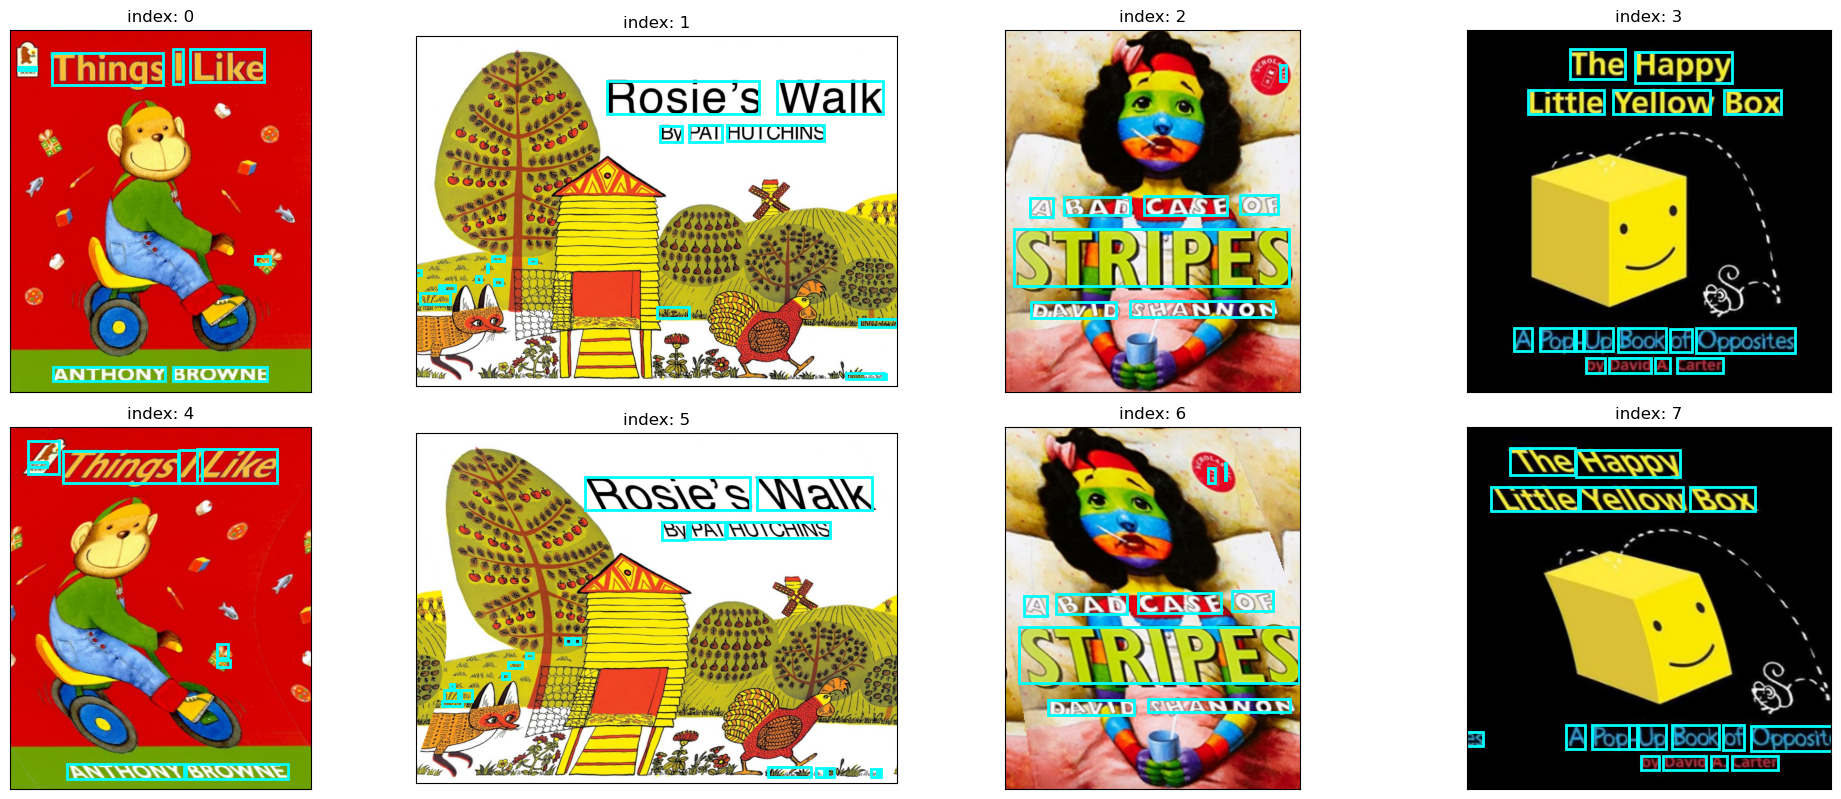

In [29]:
plt.figure(figsize=(20,20))

for i, img_path in enumerate(img_path_list):
    plt.subplot(5, 4, i+1)
    plt.title(f'index: {i}')
    
    text_pos_list = google_ocr_text_pos_list[i][1]
    text_list = google_ocr_text_list[i][1]
    text = ', '.join(text_list)

    for i, text_pos in enumerate(text_pos_list):
        if i == 0: continue
        w = text_pos[2][0]-text_pos[0][0]
        h = text_pos[2][1]-text_pos[0][1]
        rect = patches.Rectangle(
            (text_pos[0]),
            w, h,
            linewidth=2,
            edgecolor='cyan',
            fill=False
        )
        plt.gca().add_patch(rect)

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

In [30]:
google_ocr_text_list

[(0,
  ['WALKER\nThings I Like\nOLD\nANTHONY BROWNE',
   'WALKER',
   'Things',
   'I',
   'Like',
   'OLD',
   'ANTHONY',
   'BROWNE']),
 (1,
  ["l\nال .\nIllmin\nW\nال\nmiNk.\nWW\nVIL\nRosie's Walk\nBy PAT HUTCHINS\nSMPN\nWushnicia\naniven.",
   'l',
   'ال',
   '.',
   'Illmin',
   'W',
   'ال',
   'miNk',
   '.',
   'WW',
   'VIL',
   "Rosie's",
   'Walk',
   'By',
   'PAT',
   'HUTCHINS',
   'SMPN',
   'Wushnicia',
   'aniven',
   '.']),
 (2,
  ['STIC\nA BAD CASE OF\nSTRIPES\nDAVID SHANNON',
   'STIC',
   'A',
   'BAD',
   'CASE',
   'OF',
   'STRIPES',
   'DAVID',
   'SHANNON']),
 (3,
  ['The Happy\nLittle Yellow Box\nA Pop-Up Book of Opposites\nby David A. Carter',
   'The',
   'Happy',
   'Little',
   'Yellow',
   'Box',
   'A',
   'Pop',
   '-',
   'Up',
   'Book',
   'of',
   'Opposites',
   'by',
   'David',
   'A.',
   'Carter']),
 (4,
  ['B\nWALKER\nThings/Like\n52\nDID\nANTHONY BROWNE',
   'B',
   'WALKER',
   'Things',
   '/',
   'Like',
   '52',
   'DID',
   'ANTHONY',


### step 3-2 Keras-OCR

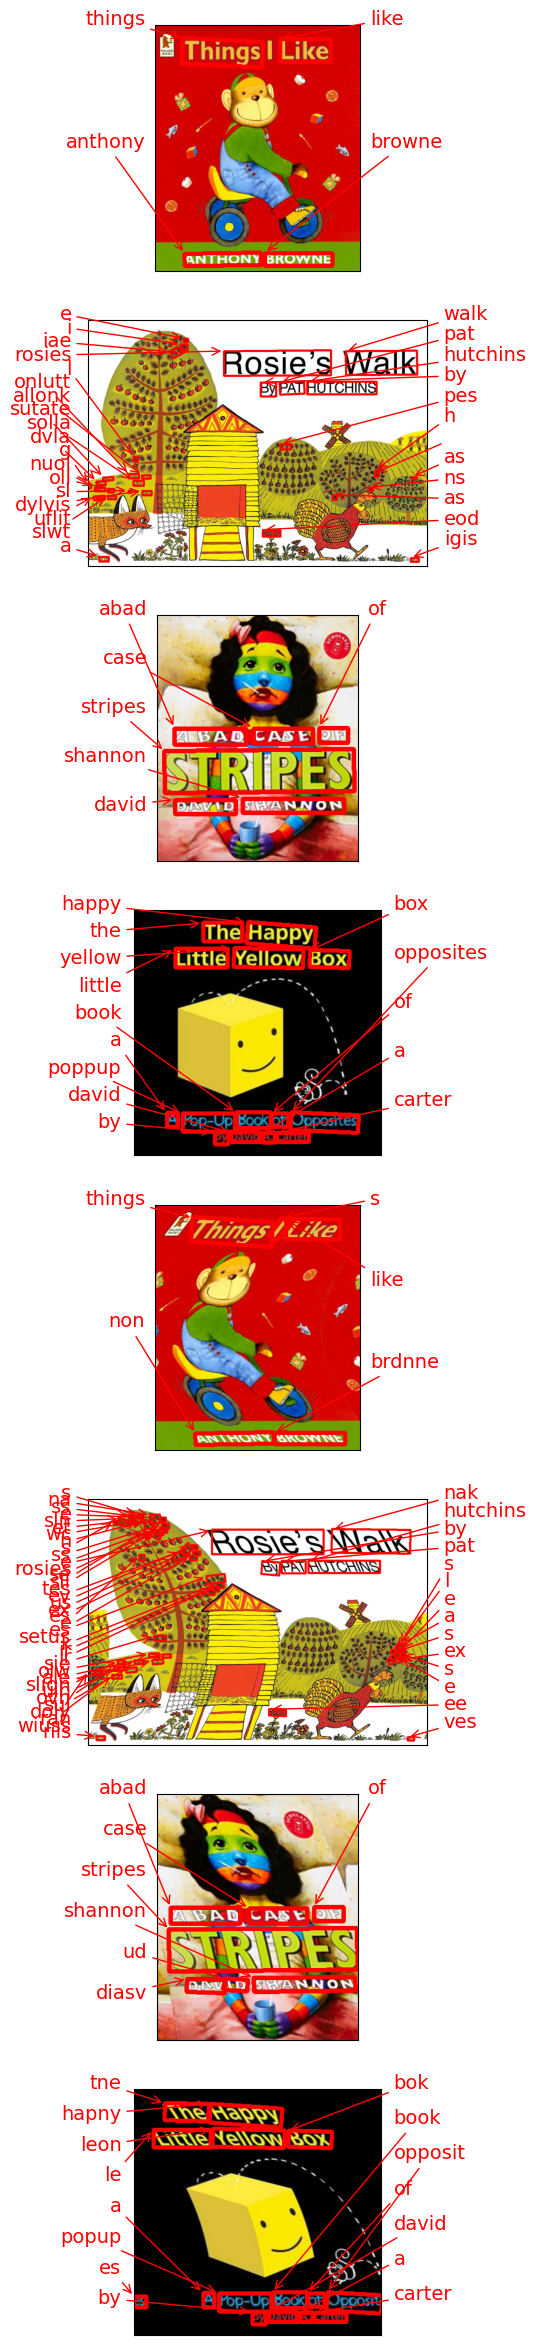

In [31]:
draw_keras_ocr(images, prediction_groups)

In [32]:
keras_ocr_text_list

[[0, ('like', 'things', 'anthony', 'browne')],
 [1,
  ('e',
   'i',
   'iae',
   'rosies',
   'walk',
   'pat',
   'hutchins',
   'by',
   'pes',
   'l',
   'h',
   '',
   'onlutt',
   'allonk',
   'as',
   'sutate',
   'solla',
   'dvla',
   'g',
   'nuol',
   'ns',
   'oll',
   'sl',
   'dylvis',
   'as',
   'uflit',
   'slwt',
   'eod',
   'a',
   'igis')],
 [2, ('of', 'abad', 'case', 'stripes', 'shannon', 'david')],
 [3,
  ('the',
   'happy',
   'little',
   'yellow',
   'box',
   'book',
   'a',
   'opposites',
   'poppup',
   'of',
   'david',
   'by',
   'a',
   'carter')],
 [4, ('things', 'like', 's', 'non', 'brdnne')],
 [5,
  ('s',
   'na',
   'ss',
   'e',
   'sln',
   'wc',
   'et',
   'n',
   's',
   'ss',
   'e',
   'se',
   'rosies',
   'nak',
   'sll',
   'tes',
   'ev',
   'us',
   'es',
   'ex',
   'e',
   'es',
   'hutchins',
   'pat',
   'by',
   'setus',
   'k',
   'ir',
   'ir',
   'sie',
   's',
   'l',
   'e',
   'a',
   's',
   'olw',
   's',
   'ale',
   'ex',


### step 3-3 Tesseract 

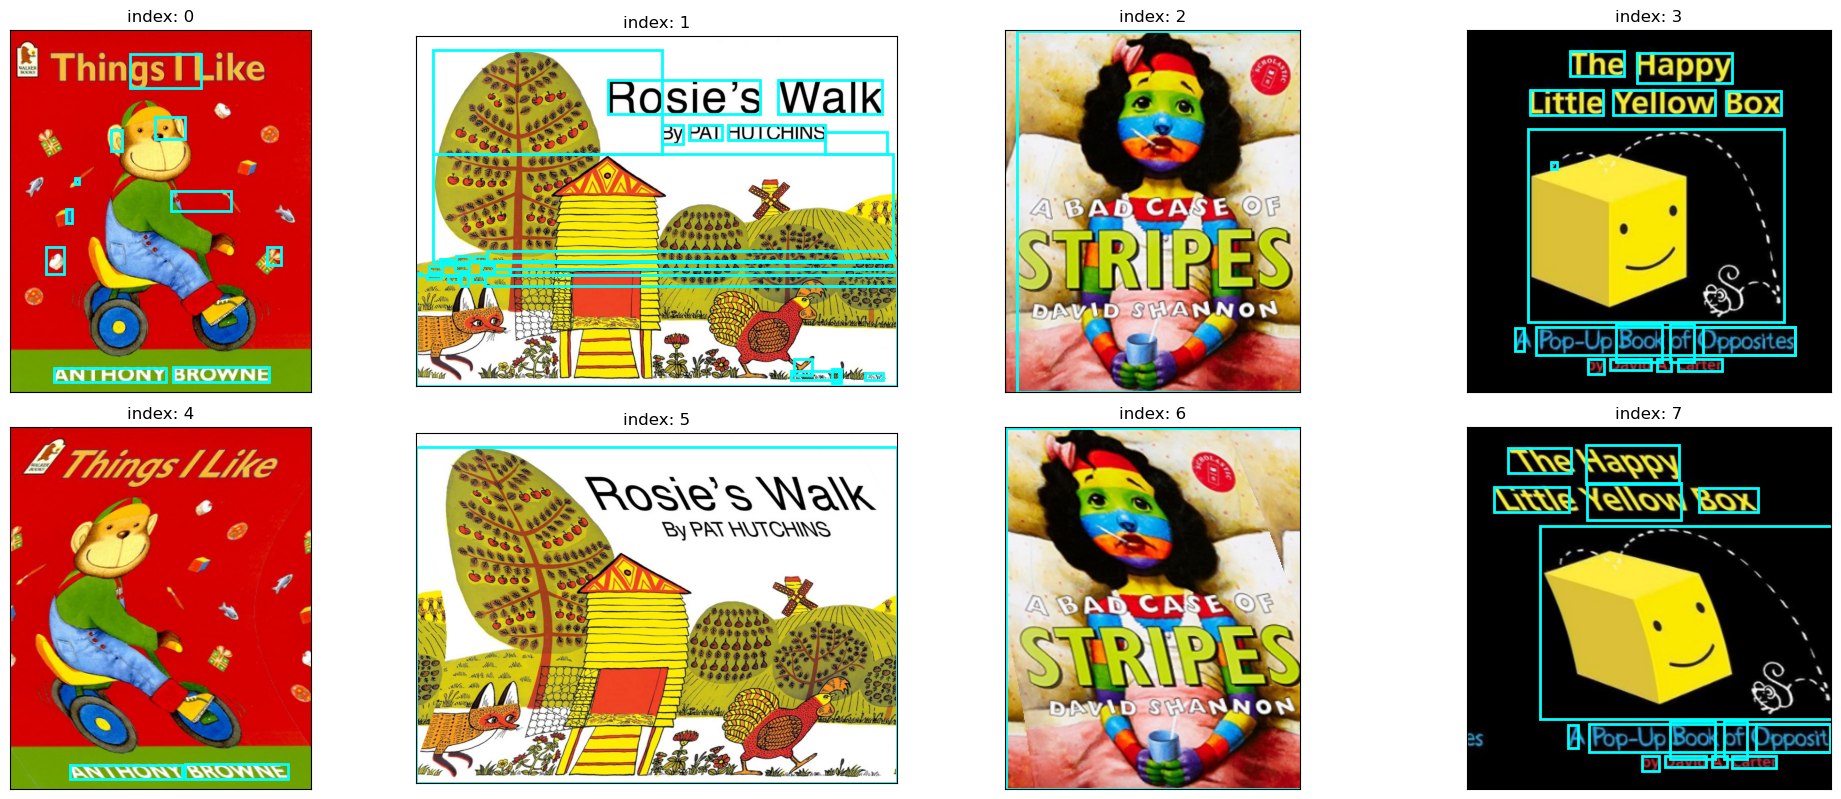

In [33]:
plt.figure(figsize=(20,20))

for i, img_path in enumerate(img_path_list):
    plt.subplot(5, 4, i+1)
    plt.title(f'index: {i}')
    
    text_pos_list = tesseract_ocr_text_pos_list[i][1]
    text_list = tesseract_ocr_text_list[i][1]
    text = ', '.join(text_list)

    for text_pos in text_pos_list:
        w = text_pos[2][0]-text_pos[0][0]
        h = text_pos[2][1]-text_pos[0][1]
        rect = patches.Rectangle(
            (text_pos[0]),
            w, h,
            linewidth=2,
            edgecolor='cyan',
            fill=False
        )
        plt.gca().add_patch(rect)

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)

    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

In [34]:
tesseract_ocr_dict

{'1.png': {'text_list': ['gsil\n',
   'mm\n',
   '¢\n',
   'a\n',
   ':.\n',
   '4 bs\n',
   'é\n',
   'Ye\n',
   'ANTHONY\n',
   ''],
  'cropped_image_dict': {'./images/ocr/picturebooks/output\\1_0000.png': [(135,
     26),
    (216, 26),
    (216, 65),
    (135, 65)],
   './images/ocr/picturebooks/output\\1_0001.png': [(163, 98),
    (197, 98),
    (197, 122),
    (163, 122)],
   './images/ocr/picturebooks/output\\1_0002.png': [(114, 112),
    (126, 112),
    (126, 136),
    (114, 136)],
   './images/ocr/picturebooks/output\\1_0003.png': [(73, 167),
    (78, 167),
    (78, 173),
    (73, 173)],
   './images/ocr/picturebooks/output\\1_0004.png': [(63, 202),
    (70, 202),
    (70, 217),
    (63, 217)],
   './images/ocr/picturebooks/output\\1_0005.png': [(182, 181),
    (249, 181),
    (249, 204),
    (182, 204)],
   './images/ocr/picturebooks/output\\1_0006.png': [(40, 244),
    (61, 244),
    (61, 275),
    (40, 275)],
   './images/ocr/picturebooks/output\\1_0007.png': [(290, 244),
 

### step 3-4 모델 평가 기준

- Text 인식 정확도 : 책을 똑바로 놓은 원본 이미지에서 인식해야 하는 필수 텍스트를 얼마나 인식했는가 글자수 기준
- 기울어진 Text 인식 정확도: 사용자가 유아인 점을 고려하여 책 표지 이미지가 똑바로 인식되지 않고 기울어진 경우에도 필수 텍스트를 얼마나 인식하는가 글자수 기준


책 표지 정보에서 필수적으로 인식해야 하는 글자가 있다. 책 제목, 저자명, 설명 등 책표지에서 주요한 정보가 필수 인식 글자이다. 
이것을 각각 OCR 모델에서 얼마나 인식했는지 글자수를 가지고 비교하자. 
그리고 인식 정확도에 대한 인식율을 백분율로 나타내에 비교하자. 

## Step4. 결과 분석과 결론 제시

<img src='https://user-images.githubusercontent.com/95423215/238202509-a385de40-f475-47b3-a054-9b0f5e497696.png' width='80%' height='80%' >

3가지 OCR 모델에 대해서 정상적인 원본 이미지와 기울어진 이미지를 비교하여 필수 인식 글자수와 각각의 모델에서 인식한 글자수를 비교하였다. 
<img src='https://user-images.githubusercontent.com/95423215/238203035-9a6fcc50-00d6-4d30-8496-766106286c2e.png'>

3가지 OCR 모델을 비교 검토한 결과, 정상적인 원본 Text 인식 정확도 100%이고, 기울어진 Text에 대한 인식율도 99%인 **Google-OCR**를 선정하였다. 

# 회고

- 처음에 Google-OCR을 가입절차 복잡해 하지 않으려다가 마지막에 했었는데, 하기를 잘했다 생각한다. 인식율이 좋아서 만족스러웠다. 
- 영문텍스트만 해보았는데, 한글 텍스트도 나중에 도전해 봐야겠다. 


### 참고자료

https://github.com/HRPzz/AIFFEL/blob/main/EXPLORATION/Node_15/%5BE-15%5D%20OCR.ipynb